In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

use_ema=True
tikr='^GSPC'
start='2022-01-01'

_stock_price_history=yf.Ticker(tikr).history(start=start)#,end='2021-01-01')
_stock_price_history.dropna(inplace=True)

_market=yf.Ticker('^GSPC').history(start=start)#,end='2021-01-01')

In [2]:
# Strategy to find optimal moving average window combinations
best_return = -float('inf')
best_windows = None
window_combinations = []
results = []

sort_by='return' # or 'hit_rate'

#use_ema=False
for use_ema in [True,False]:
    # Test different window combinations
    for short_window in range(5, 30):
        for long_window in range(short_window + 1, 100):
            stock_price_history = _stock_price_history.copy()
            windows = [short_window, long_window]
            
            # Calculate moving averages
            for window in windows:
                if use_ema:
                    stock_price_history[f'MA{window}'] = stock_price_history['Close'].ewm(span=window, adjust=False, min_periods=window).mean()
                else:
                    stock_price_history[f'MA{window}'] = stock_price_history['Close'].rolling(window=window).mean()
            
            # Create signals
            stock_price_history['MA_cross'] = np.where(
                stock_price_history[f'MA{windows[0]}'] > stock_price_history[f'MA{windows[1]}'], 1, -1)
            stock_price_history['crossover'] = stock_price_history['MA_cross'].diff()
            
            # Get crossover dates
            crossover_dates = stock_price_history[stock_price_history['crossover'] != 0]
            if len(crossover_dates[crossover_dates['crossover'] == 2]) == 0 or len(crossover_dates[crossover_dates['crossover'] == -2]) == 0:
                continue
                
            first_buy_date = crossover_dates[crossover_dates['crossover'] == 2].index[0]
            last_sell_date = crossover_dates[crossover_dates['crossover'] == -2].index[-1]
            
            crossover_dates = crossover_dates.loc[first_buy_date:last_sell_date].copy()
            crossover_dates.dropna(inplace=True)
            
            # Calculate returns
            crossover_dates['return'] = np.where(crossover_dates['crossover']==2, 0, crossover_dates['Close'].pct_change())
            returns = crossover_dates['return'].to_numpy(dtype=float)
            returns = returns[returns!=0]
            
            if len(returns) > 0:
                total_return = np.prod(1+returns)-1
                hit_rate = len(returns[returns>0])/len(returns)

                if total_return>0:
                    results.append({
                        'windows': windows,
                        'return': total_return,
                        'hit_rate': hit_rate,
                        'trades': len(crossover_dates),
                        'EMA?': use_ema,
                    })
                else:
                    windows = windows[::-1]
                    total_return = -total_return
                    hit_rate = 1-hit_rate
                    results.append({
                        'windows': windows,
                        'return': total_return,
                        'hit_rate': hit_rate,
                        'trades': len(crossover_dates),
                        'EMA?': use_ema,
                    })
                    
# Sort results by return and display top 5
results_df = pd.DataFrame(results).sort_values(sort_by, ascending=False)
print("Top 5 window combinations:")
print(results_df.head())

print(f"{tikr} returns without trading:{(_stock_price_history.Close.iloc[-1]-_stock_price_history.Close.iloc[0])*100/(_stock_price_history.Close.iloc[0]):.2f}%")
print(f"Market returns:{(_market.Close.iloc[-1]-_market.Close.iloc[0])*100/(_market.Close.iloc[0]):.2f}%")
print(f"Total time: {_stock_price_history.index[-1]-_stock_price_history.index[0]}")

Top 5 window combinations:
      windows    return  hit_rate  trades   EMA?
2421  [9, 11]  0.529470  0.581395      86  False
2422  [9, 12]  0.511102  0.558824      68  False
2332  [8, 12]  0.505659  0.645161      62  False
2331  [8, 11]  0.488876  0.684211      76  False
2423  [9, 13]  0.456324  0.482759      58  False
^GSPC returns without trading:25.93%
Market returns:25.93%
Total time: 1124 days 00:00:00


Using SMA
Strategy: Buy when MA9 > MA11, sell when MA9 < MA11
Number of trades: 86
Hit rate: 58.14%
Total time: 1083 days 00:00:00


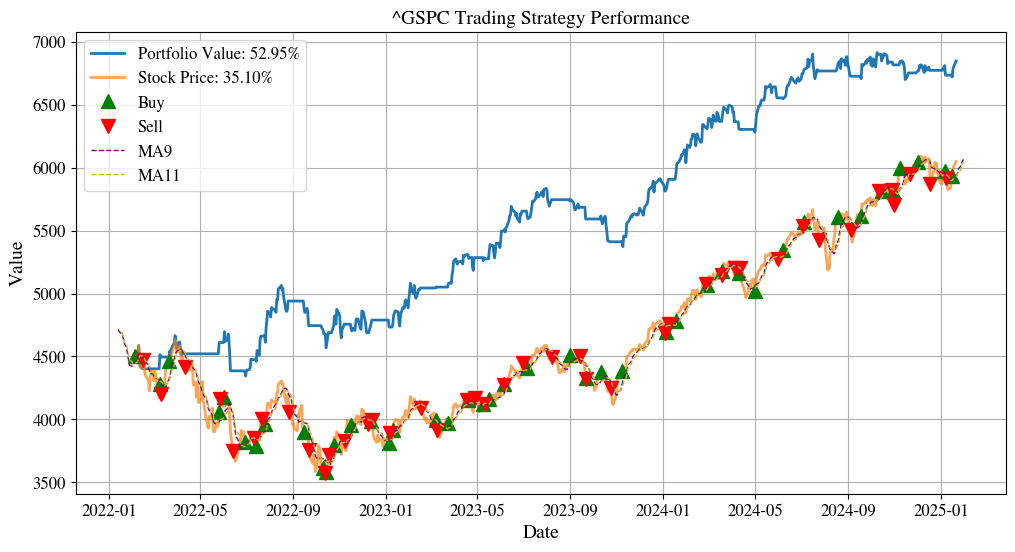

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from backtesting import Backtest#backtest, plot_strategy

windows=results_df.iloc[0]['windows']#[9,11]#
use_ema=results_df.iloc[0]['EMA?']#False#
# when the short term moving average is above the long term moving average, the stock is considered bullish
stock_price_history=_stock_price_history.copy()

if use_ema:
    print(f"Using EMA")
else:
    print(f"Using SMA")
print(f"Strategy: Buy when MA{windows[0]} > MA{windows[1]}, sell when MA{windows[0]} < MA{windows[1]}")

for window in windows:
    if use_ema:
        stock_price_history['MA'+str(window)]=stock_price_history['Close'].ewm(span=window, adjust=False, min_periods=window).mean()
    else:
        stock_price_history['MA'+str(window)]=stock_price_history['Close'].rolling(window=window).mean()

# Create crossover signals
stock_price_history['MA_cross'] = np.where(
    stock_price_history['MA'+str(windows[0])] > stock_price_history['MA'+str(windows[1])], 1, -1)
# Find where the signal changes (crossover points)
stock_price_history['crossover'] = stock_price_history['MA_cross'].diff()

# Get dates where crossovers occur
crossover_dates = stock_price_history[stock_price_history['crossover'] != 0].copy()
crossover_dates['signal'] = np.where(crossover_dates['crossover'] == 2, 'buy', 'sell')

backtester=Backtest(crossover_dates, stock_price_history, None)
backtester.run_backtest()


plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

fig, ax = plt.subplots(figsize=(12,6))
ax=backtester.plot_strategy(tikr='SP500',ax=ax)
ax.plot(stock_price_history['MA'+str(windows[0])],label='MA'+str(windows[0]),linestyle='--',linewidth=1,color='purple')
ax.plot(stock_price_history['MA'+str(windows[1])],label='MA'+str(windows[1]),linestyle='--',linewidth=1,color='tab:olive')

ax.set_title(f"{tikr} Trading Strategy Performance")
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True)
fig.savefig('figures/'+tikr+'_portfolio_performance.png',dpi=300,bbox_inches='tight')
plt.show()

In [4]:
# Alpha calculation
market_returns =(_market['Close'].iloc[-1]-_market['Close'].iloc[0])*100/_market['Close'].iloc[0]
strategy_returns = backtester.portfolio_returns
rf = 0.01

alpha = strategy_returns - rf - (market_returns - rf)
print(f'Alpha: {alpha:.2f}%')

Alpha: 27.01%


In [6]:
backtester.stock_price_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA9,MA11,MA_cross,crossover,signal
Date,,,,,,,,,,,,
2022-02-03 00:00:00-05:00,4535.410156,4542.879883,4470.390137,4477.439941,4401970000,0.0,0.0,4444.864421,4444.040882,1,2.0,buy
2022-02-04 00:00:00-05:00,4482.790039,4539.660156,4451.500000,4500.529785,4706290000,0.0,0.0,4454.908854,4445.659047,1,0.0,hold
2022-02-07 00:00:00-05:00,4505.750000,4521.859863,4471.470215,4483.870117,4228480000,0.0,0.0,4469.066623,4453.470881,1,0.0,hold
2022-02-08 00:00:00-05:00,4480.020020,4531.319824,4465.399902,4521.540039,4459620000,0.0,0.0,4488.134386,4463.599077,1,0.0,hold
2022-02-09 00:00:00-05:00,4547.000000,4590.029785,4547.000000,4587.180176,4524350000,0.0,0.0,4517.097765,4484.574529,1,0.0,hold
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-14 00:00:00-05:00,5859.270020,5871.919922,5805.419922,5842.910156,4142280000,0.0,0.0,5889.053331,5898.114524,-1,0.0,hold
2025-01-15 00:00:00-05:00,5905.209961,5960.609863,5905.209961,5949.910156,4544570000,0.0,0.0,5896.640028,5896.211825,1,2.0,buy
2025-01-16 00:00:00-05:00,5963.609863,5964.689941,5930.720215,5937.339844,4285810000,0.0,0.0,5904.283366,5898.975453,1,0.0,hold
